# Analyze Catchment Characteristics

# TODO: CHANGE THIS INFORMATION
This code provides an example on how to prepare the NHDPlus High-Resolution dataset for use in the Meander Characterization package. The information can be downloaded from the following website: https://www.usgs.gov/core-science-systems/ngp/national-hydrography/nhdplus-high-resolution.

In this workflow, we will use the HUC 0602 NHDPlus High-Resolution that is saved in the `NHDPlus_HR/raw_data/` folder, and the resulting files will be saved in the `./NHDPlus_HR/processed_data/NHDPlus_H_0602_HU4_GDB/` folder. 

## Extracting NHD Information
### Importing Packages

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl

In [18]:
# Importing Packages
import geopandas
import fiona
import os
import time
import copy
import numpy as np
import pyproj
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from IPython.display import Image, display, HTML
from joblib import Parallel, delayed
import plotly.io as pio
import ipywidgets as widgets
from IPython.display import display
from scipy.spatial import Delaunay
from scipy.spatial.distance import euclidean
import warnings

# Importing pyMeander Packages
from WigglyRivers import RiverDatasets as Rivers
from WigglyRivers import RiverFunctions as RF
from WigglyRivers import ExtractNHDPlusHRData as NHD
from WigglyRivers.utilities import utilities as utl
from WigglyRivers.utilities import filesManagement as FM
from WigglyRivers import Logger
from WigglyRivers import WaveletTreeFunctions as WTFunc
from WigglyRivers import graphs

In [4]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [5]:
# Start Logger
logger = Logger(console=False)

In [15]:
# Parameters
huc_id = '0602'
# huc_id = '0104'
# huc_id = '0601'
# huc_id = '0513'
path_nhd = f'./NHDPlus_HR/raw_data/NHDPlus_H_{huc_id}_HU4_GDB/'
path_output = f'./NHDPlus_HR/processed_data/NHDPlus_H_{huc_id}_HU4_GDB/'
path_river_routing = f'{path_output}/river_routing/'
path_meander_info = f'{path_output}/meanders_V2/'
file_name = f'NHDPlus_H_{huc_id}_HU4_GDB.gdb'
projection = 'esri:102003'

### Compile Information

We start by compiling the information of the catchment data

In [9]:
# -----------------------------
# Information
# -----------------------------
path_tables = f'{path_output}/tables/'
path_coords = f'{path_output}/coordinates/'
# -----------------------------
# Create Rivers object
# -----------------------------
rivers = Rivers(logger=logger)
# -----------------------------
# Add files
# -----------------------------
rivers.add_files(path_data=path_tables, huc04=huc_id, path_coords=path_coords,
                comid_id='nhdplusid', load_coords=False)
# -----------------------------
# load Linking Files
# -----------------------------
linking_network_file = f'{path_river_routing}/linking_network.feather'
comid_network_file = f'{path_river_routing}/comid_network.hdf5'
rivers.load_linking_network(linking_network_file)
# -----------------------------
# load HUC files extracted
# -----------------------------
huc_list = rivers.load_huc_list_in_comid_network(comid_network_file)
huc = huc_list[0]
headwaters = rivers.load_extracted_in_comid_network(
    comid_network_file, huc=huc)
headwaters = headwaters[huc]
print(headwaters)

['25000300004620' '25000300008327' '25000300015040' ... '25000300018146'
 '25000300001774' '25000300022831']


In [16]:
# Extract folders in the meander information
folders = utl.get_folders(path_meander_info)
folders = np.sort(folders)
print(folders)

['0_99' '100_599' '10100_10599' '10600_11099' '1100_1599' '11100_11599'
 '11600_12099' '12100_12599' '12600_13099' '13100_13599' '13600_14099'
 '14100_14476' '1600_2099' '2100_2599' '2600_3099' '3100_3599' '3600_4099'
 '4100_4599' '4600_5099' '5100_5599' '5600_6099' '600_1099' '6100_6599'
 '6600_7099' '7100_7599' '7600_8099' '8100_8599' '8600_9099' '9100_9599'
 '9600_10099']


In [138]:
# Compile meander information
for i, folder in enumerate(folders):
    print(f'Folder {i+1}/{len(folders)}')
    # Load dataframe
    meander_data = FM.load_data(
        f'{path_meander_info}{folder}/meander_database.feather',
        pandas_dataframe=True)
    # Remove meanders with full-menader sinuosity less than 1.05
    meander_data = meander_data[meander_data['sigma_hm'] > 1.1]
    meander_data = meander_data[meander_data['so'] >= 1]
    meander_data = meander_data[meander_data['a_hm'] < 1]
    meander_data = meander_data[meander_data['a_hm'] > -1]
    meander_data = meander_data[meander_data['a_fm'] < 1]
    meander_data = meander_data[meander_data['a_fm'] > -1]
    if i == 0:
        meander_data_all = meander_data
    else:
        meander_data_all = pd.concat([meander_data_all, meander_data])

# Save Data
FM.save_data(meander_data_all, f'{path_meander_info}',
             file_name='meander_database_all.feather')

Folder 1/30
Folder 2/30
Folder 3/30
Folder 4/30
Folder 5/30
Folder 6/30
Folder 7/30
Folder 8/30
Folder 9/30
Folder 10/30
Folder 11/30
Folder 12/30
Folder 13/30
Folder 14/30
Folder 15/30
Folder 16/30
Folder 17/30
Folder 18/30
Folder 19/30
Folder 20/30
Folder 21/30
Folder 22/30
Folder 23/30
Folder 24/30
Folder 25/30
Folder 26/30
Folder 27/30
Folder 28/30
Folder 29/30
Folder 30/30


In [139]:
print(meander_data_all.columns)
meander_data_all['so'].min()

Index(['id', 'id_reach', 'huc04_n', 'huc_n', 'start_comid', 'comid', 'scale',
       'x_start_river', 'y_start_river', 'translate', 'id_meander',
       'idx_start', 'idx_end', 'x_start', 'x_end', 'y_start', 'y_end',
       's_start', 's_end', 's_middle', 'idx_start_o', 'idx_end_o', 'x', 'y',
       'x_o', 'y_o', 'automatic_flag', 'inflection_flag', 'tree_id', 'x_inf',
       'y_inf', 's_inf', 'x_c_max', 'y_c_max', 'c_max', 's_c_max', 'lambda_fm',
       'lambda_hm', 'L_fm', 'L_hm', 'sigma_fm', 'sigma_hm', 'so', 'skewness',
       'flatness', 'R_hm', 'curvature_side', 'a_fm', 'lambda_fm,u',
       'lambda_fm,d', 'a_hm', 'lambda_hm,u', 'lambda_hm,d', 'A_hm', 'A_fm',
       'lambda', 'FF', 'L_l', 'L_n', 's_n', 's_l', 'index'],
      dtype='object')


1.0

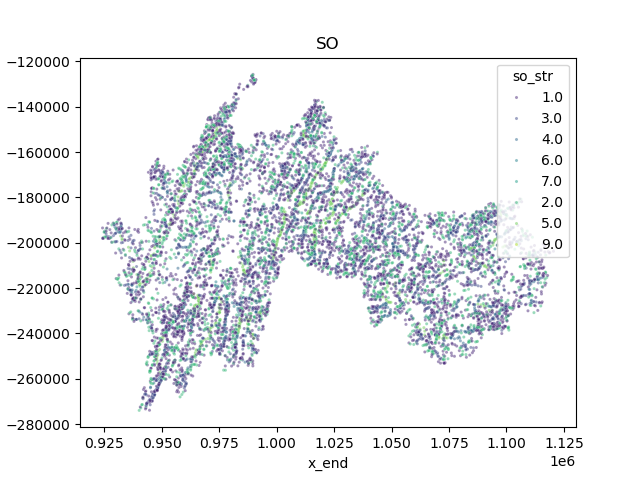

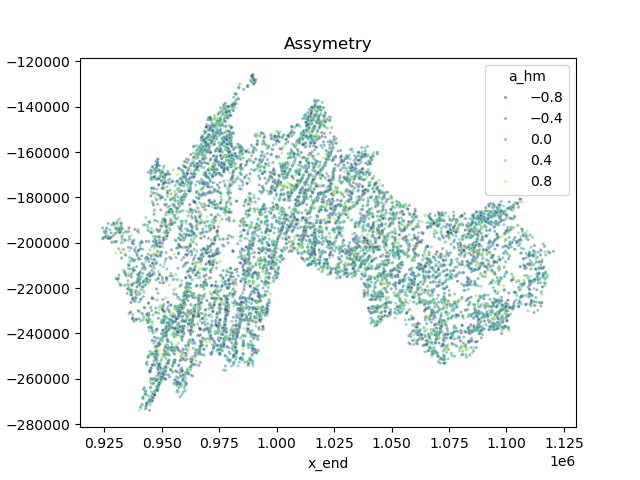

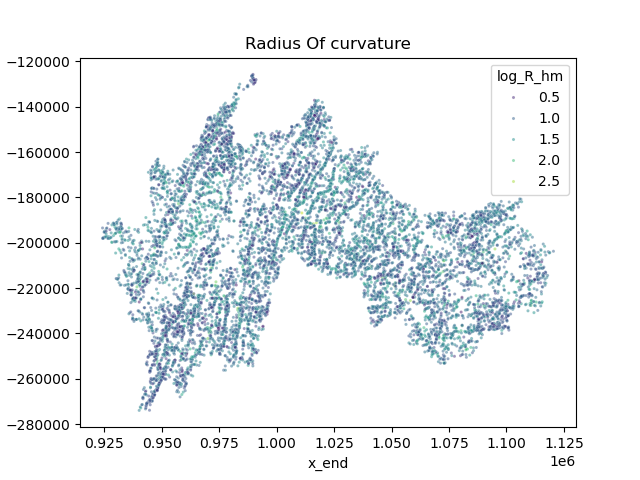

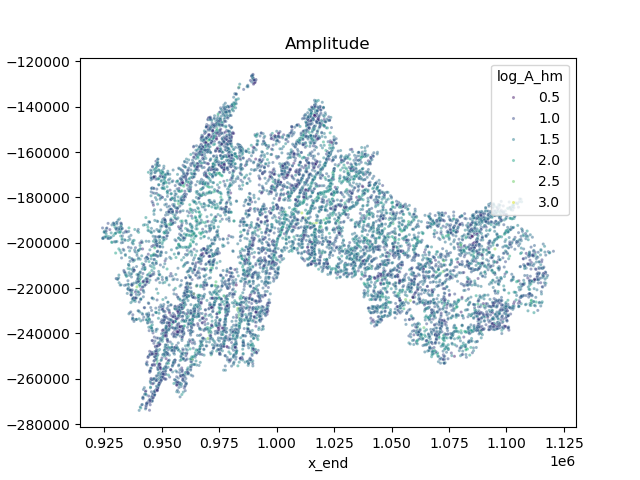

In [140]:
# Plot information
meander_data_all_to_plot = copy.deepcopy(meander_data_all)
# meander_data_all_to_plot = meander_data_all[meander_data_all['FF'] > 2]
meander_data_all_to_plot['log_lambda'] = np.log10(meander_data_all_to_plot['lambda'])
meander_data_all_to_plot['log_lambda_hm'] = np.log10(meander_data_all_to_plot['lambda_hm'])
meander_data_all_to_plot['log_lambda_fm'] = np.log10(meander_data_all_to_plot['lambda_fm'])
meander_data_all_to_plot['log_L_hm'] = np.log10(meander_data_all_to_plot['L_hm'])
meander_data_all_to_plot['log_L_fm'] = np.log10(meander_data_all_to_plot['L_fm'])
meander_data_all_to_plot['log_R_hm'] = np.log10(meander_data_all_to_plot['R_hm'])
meander_data_all_to_plot['log_A_hm'] = np.log10(meander_data_all_to_plot['A_hm'])
meander_data_all_to_plot['log_A_fm'] = np.log10(meander_data_all_to_plot['A_fm'])
meander_data_all_to_plot['so_str'] = meander_data_all_to_plot['so'].astype(str)
so_str_order = meander_data_all_to_plot['so_str'].unique()
plt.figure()
plt.title('SO')
sns.scatterplot(x='x_end', y='y_end', hue='so_str', hue_order=so_str_order,
                palette='viridis', data=meander_data_all_to_plot,
                s=5, alpha=0.5)
plt.show()

plt.figure()
plt.title('Assymetry')
sns.scatterplot(x='x_end', y='y_end', hue='a_hm',
                palette='viridis', data=meander_data_all_to_plot,
                s=5, alpha=0.5)
plt.show()

plt.figure()
plt.title('Radius Of curvature')
sns.scatterplot(x='x_end', y='y_end', hue='log_R_hm',
                palette='viridis', data=meander_data_all_to_plot,
                s=5, alpha=0.5)
plt.show()

plt.figure()
plt.title('Amplitude')
sns.scatterplot(x='x_end', y='y_end', hue='log_A_hm',
                palette='viridis', data=meander_data_all_to_plot,
                s=5, alpha=0.5)
plt.show()


(10633, 71)


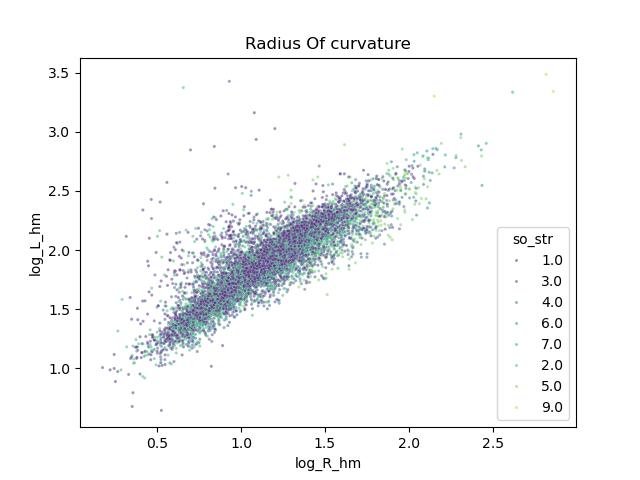

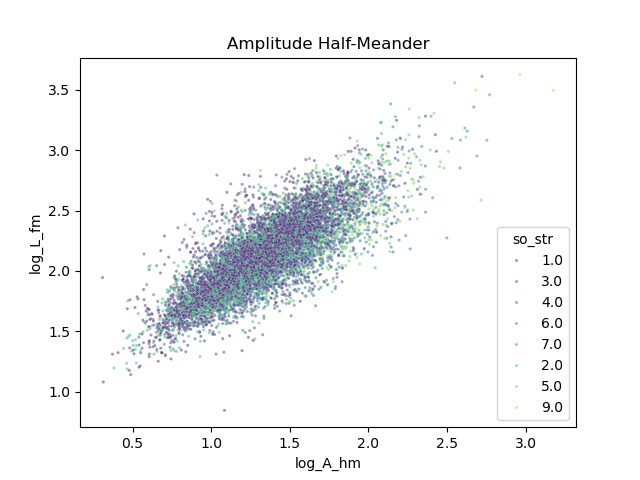

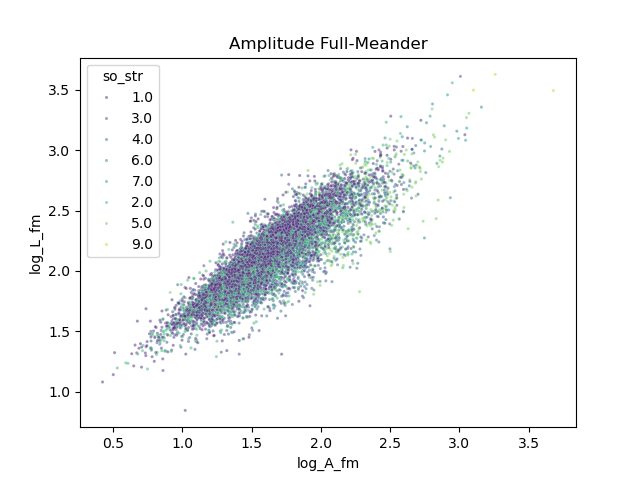

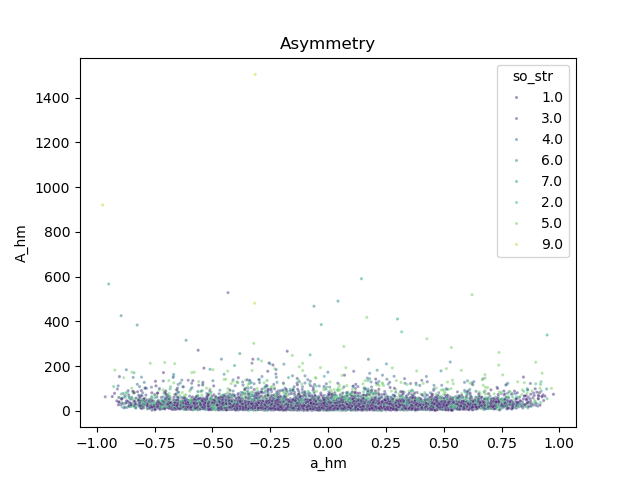

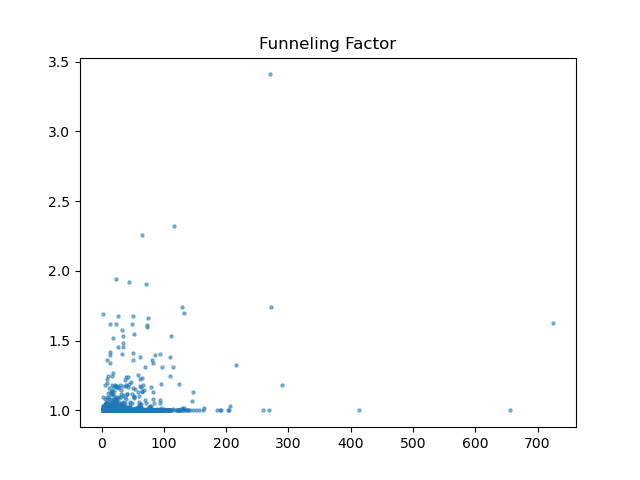

In [141]:
print(meander_data_all_to_plot.shape)
plt.close('all')
plt.figure()
plt.title('Radius Of curvature')
sns.scatterplot(x='log_R_hm', y='log_L_hm', hue='so_str', hue_order=so_str_order,
                palette='viridis', data=meander_data_all_to_plot,
                s=5, alpha=0.5)
plt.show()

plt.figure()
plt.title('Amplitude Half-Meander')
sns.scatterplot(x='log_A_hm', y='log_L_fm', hue='so_str', hue_order=so_str_order,
                palette='viridis', data=meander_data_all_to_plot,
                s=5, alpha=0.5)
plt.show()

plt.figure()
plt.title('Amplitude Full-Meander')
sns.scatterplot(x='log_A_fm', y='log_L_fm', hue='so_str', hue_order=so_str_order,
                palette='viridis', data=meander_data_all_to_plot,
                s=5, alpha=0.5)
plt.show()
plt.figure()
plt.title('Asymmetry')
sns.scatterplot(x='a_hm', y='A_hm', hue='so_str', hue_order=so_str_order,
                palette='viridis', data=meander_data_all_to_plot,
                s=5, alpha=0.5)
plt.show()

plt.figure()
plt.title('Funneling Factor')
ff = meander_data_all_to_plot['FF'].values
sigma_hm = meander_data_all_to_plot['R_hm'].values
plt.scatter(sigma_hm, ff, s=5, alpha=0.5)
# sns.scatterplot(x='sigma_hm', y='FF', 
#                 palette='viridis', data=meander_data_all_to_plot,
#                 s=5, alpha=0.5)
plt.show()

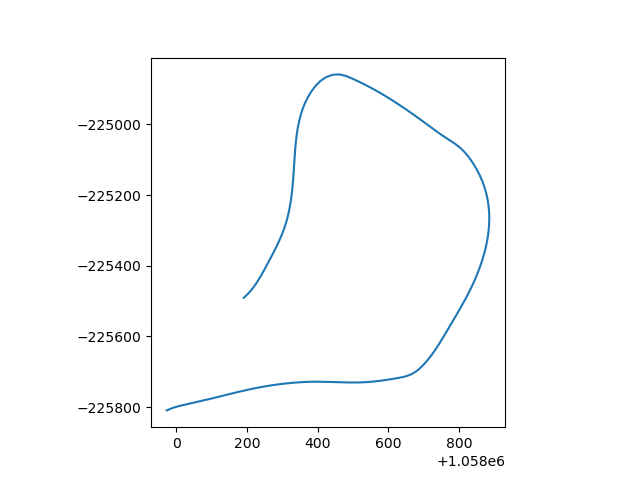

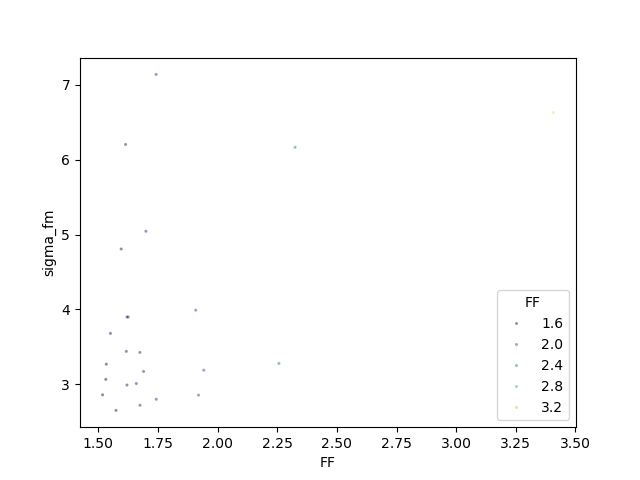

In [149]:
# Extract meanders with large FF
meander_large = meander_data_all_to_plot[meander_data_all_to_plot['FF'] > 1.5]
# meander_large = meander_large[meander_large['sigma_hm'] < 1.5]
max_sn = np.argmax(meander_large['FF'])

id_meander = max_sn
x = meander_large['x'].values[id_meander]
y = meander_large['y'].values[id_meander]

plt.figure()
plt.plot(x, y, '-')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


plt.figure()
sns.scatterplot(x='FF', y='sigma_fm', hue='FF',
                palette='viridis', data=meander_large,
                s=5, alpha=0.5)
plt.show()

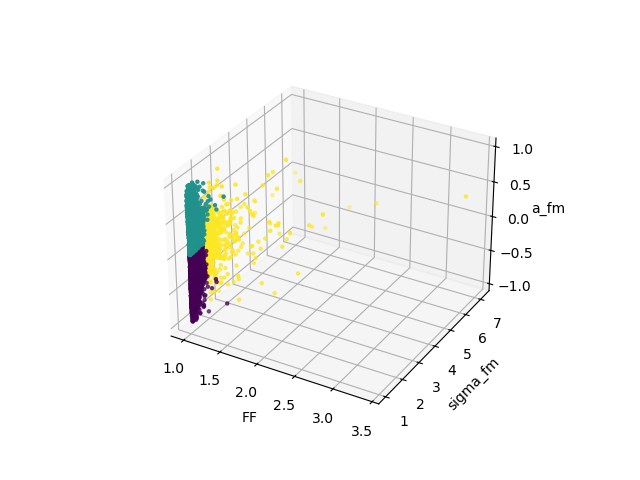

In [148]:
# Test possible clustering algorithm K-means
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = ['FF', 'sigma_fm', 'a_fm']

meander_features = meander_data_all_to_plot[features]
# remove nan
meander_features = meander_features.dropna()
# Standardize the data
meander_features = meander_features.values

# Scale the data
scaler = StandardScaler()
# meander_features = scaler.fit_transform(meander_features)

kmeans = KMeans(n_clusters=3, n_init=10, random_state=0,
                max_iter=300).fit(meander_features)

# Do 3D plot of the clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(meander_features[:, 0], meander_features[:, 1],
           meander_features[:, 2], c=kmeans.labels_, s=5, cmap='viridis')
ax.set_xlabel('FF')
ax.set_ylabel('sigma_fm')
ax.set_zlabel('a_fm')
plt.show()



In [155]:
# Compile GWS data for curvature and angle
path_meander_info = f'{path_output}/meanders/'
# Extract folders in the meander information
folders = utl.get_folders(path_meander_info)
folders = np.sort(folders)
print(folders)
for i, folder in enumerate(folders):
    if i > 0:
        continue
    values = folder.split('_')
    range_values = [int(i) for i in values]
    range_values[-1] += 1
    cwt_file = f'{path_meander_info}/{folder}/cwt_data.hdf5'
    headwater_vals = headwaters[range_values[0]:range_values[1]]
    for i_hw, hw in enumerate(headwater_vals):
        try:
            data = FM.load_data(cwt_file, keys=f'{hw}')
        except KeyError:
            continue

        if len(data) == 0:
            continue

        w = data[hw]['morlet']['w_m']
        gm_w_m = 10**np.mean(np.log10(w))

        

        data_extract = {
            'headwater': hw,
            's': [data[hw]['morlet']['s']],
            'wavelength_c': [data[hw]['morlet']['wavelength_c']],
            'wavelength_angle': [data[hw]['morlet']['wavelength_angle']],
            'wavelength_c_scaled': [data[hw]['morlet']['wavelength_c']/gm_w_m],
            'wavelength_angle_scaled': [data[hw]['morlet']['wavelength_angle']/gm_w_m],
            'gws_c_sig': [data[hw]['morlet']['gws_c_sig']],
            'gws_angle_sig': [data[hw]['morlet']['gws_angle_sig']],
            'sawp_c_sig': [data[hw]['morlet']['sawp_c_sig']],
            'sawp_angle_sig': [data[hw]['morlet']['sawp_angle_sig']],
            }
        data_extract = pd.DataFrame(data_extract)

        if i_hw == 0:
            data_all = data_extract
        else:
            data_all = pd.concat([data_all, data_extract], axis=0)

# Save information
data_all.reset_index(drop=True, inplace=True)
FM.save_data(data_all, f'{path_meander_info}', file_name='gws_sawp_all.feather')

print('Extracted')

['0_99' '100_599']
Extracted


In [32]:
data_all

,headwater,s,wavelength_c,wavelength_angle,gws_c_sig,gws_angle_sig,sawp_c_sig,sawp_angle_sig
0,25000300004620,"[0.0, 25.20230042356845, 50.4046008471369, 75....","[142.35405215649916, 147.3741569643096, 152.57...","[142.35405215649916, 147.3741569643096, 152.57...","[4.2676831424039096e-05, 4.339905998964717e-05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 8.159339198859897e-0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,25000300008327,"[0.0, 52.08048768942096, 104.16097537884193, 1...","[294.1742752158653, 304.54830862744524, 315.28...","[294.1742752158653, 304.54830862744524, 315.28...","[9.122033716948946e-06, 8.95859558192931e-06, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,25000300015040,"[0.0, 14.720504888293316, 29.441009776586633, ...","[83.14810495150022, 86.08031654016973, 89.1159...","[83.14810495150022, 86.08031654016973, 89.1159...","[7.142370543739872e-05, 7.633288700179482e-05,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,25000300034708,"[0.0, 19.100911857754923, 38.201823715509846, ...","[107.89063526489521, 111.69539030070958, 115.6...","[107.89063526489521, 111.69539030070958, 115.6...","[5.792066313609146e-05, 6.006299090282228e-05,...","[0.0, 0.0, 0.0, 0.0, 0.0, 2.3610234887507833, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,25000300028648,"[0.0, 17.420256838860738, 34.840513677721475, ...","[98.39753153246738, 101.8675129881394, 105.459...","[98.39753153246738, 101.8675129881394, 105.459...","[0.00011954071808915797, 0.0001251553692479781...","[0.0, 0.0, 0.0, 8.573992834072122, 9.011388343...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
95,25000300003942,"[0.0, 3.7100657335089364, 7.420131467017873, 1...","[20.956138211814498, 21.695154829863515, 22.46...","[20.956138211814498, 21.695154829863515, 22.46...","[0.00017429808415138603, 0.0001905191083806288...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
96,25000300029878,"[0.0, 4.99460623380529, 9.98921246761058, 14.9...","[28.21180703184482, 29.206694258250472, 30.236...","[28.21180703184482, 29.206694258250472, 30.236...","[3.1250695753766375e-05, 3.5600995523625075e-0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
97,25000300027296,"[0.0, 4.432709969138947, 8.865419938277894, 13...","[25.037961437493756, 25.920923240730325, 26.83...","[25.037961437493756, 25.920923240730325, 26.83...","[0.00016828819903721135, 0.0001781320465142727...","[23.5274197643507, 24.91808046228232, 31.58847...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
98,25000300015533,"[0.0, 4.039990525719789, 8.079981051439578, 12...","[22.819703453429682, 23.624438557797703, 24.45...","[22.819703453429682, 23.624438557797703, 24.45...","[0.0009067075734263038, 0.0009775314315764415,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


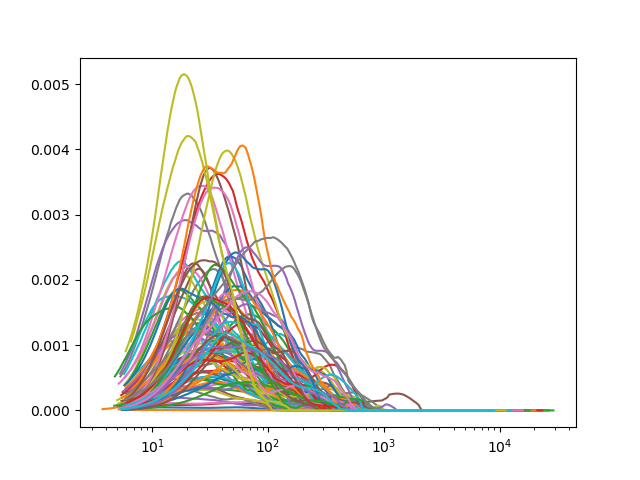

In [157]:
# Plotting all GWS data
plt.figure()
headwaters_vals = data_all['headwater'].values
for i, hw in enumerate(headwater_vals):
    plt.plot(data_all['wavelength_c_scaled'].iloc[i], data_all['gws_c_sig'].iloc[i],
             label=f'HW {hw}')
# plt.legend()
plt.xscale('log')
plt.show()